# 1. Import Required Libraries

In [18]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 2. Load Dataset, and Mean/Std Data from Training

In [19]:
demo_df = pd.read_csv("demo_dataset.csv", 
                 usecols = ['host_is_superhost', 
                            'latitude','longitude', 'property_type',
                            'room_type','accommodates','bathrooms',
                            'bedrooms','beds','amenities', 'price',
                            'instant_bookable','cancellation_policy'])

demo_df["price"] = demo_df["price"].apply(lambda x: x.replace('$','').replace(',', '').replace('.00', '')).astype("int")
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col = 0)

# 3. Data Processing

### 3.1 Visualize Initial Data

In [20]:
demo_df.head(1).transpose()

,0
host_is_superhost,f
latitude,43.6462
longitude,-79.4245
property_type,House
room_type,Entire home/apt
accommodates,10
bathrooms,3
bedrooms,5
beds,7
amenities,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""..."


### 3.2 Process Data

In [21]:
initial_samples = len(demo_df) # initial number of samples
print("Initial # of Samples: ", len(demo_df), "\n")

# Drop samples with missing values
print("DELETING SAMPLES WITH MISSING VALUES...")
demo_df = demo_df.dropna()
samples1 = len(demo_df) # current number of samples
print("--Number of Samples Removed: ", initial_samples-samples1)

# reset index
demo_df = demo_df.reset_index(drop=True)

cancellation_policies = {
    "flexible": 1,
    "moderate": 5,
    "strict_14_with_grace_period": 14,
    "super_strict_30": 30,
    "super_strict_60": 60
}
room_types = {
    "Entire home/apt": 0,
    "Private room": 1,
    "Shared room": 2
}
true_false = {
    't': 1,
    'f': 0,
    True: 1,
    False: 0
}

property_types = {
    "House" : 1,
    "Apartment" : 2,
    "Condominium" : 5,
    "Townhouse" : 3,
    "Bungalow" : 0,
    "Loft" : 4,
    "Serviced apartment" : 6,
    "Guest suite" : 7
}

# convert t/f into 1/0
print("NUMERICALIZING TRUE/FALSE...")
for i in ["host_is_superhost", "instant_bookable"]:
    demo_df[i] = demo_df[i].map(true_false)
    print(demo_df[i].value_counts())

print(" ")

# cancellation policy
print("NUMERICALIZING CANCELLATION POLICY...")
print(demo_df["cancellation_policy"].value_counts())
demo_df["cancellation_policy"] = demo_df["cancellation_policy"].map(cancellation_policies)

print(" ")

# room_type
print("NUMERICALIZING ROOM TYPE...")
accum = ["Entire home/apt", "Private room", "Shared room"]
demo_df = demo_df[demo_df["room_type"].isin(accum)]
print(demo_df["room_type"].value_counts())
demo_df["room_type"] = demo_df["room_type"].map(room_types)

print("")
print("FILTERLING AND NUMERICALIZING PROPERTY TYPES...")

print("Types of Included Properties:")
accum = ["House", "Apartment", "Condominium", "Townhouse", "Bungalow", "Loft", "Serviced apartment", "Guest suite"]
demo_df = demo_df[demo_df["property_type"].isin(accum)]
print(demo_df["property_type"].value_counts())
demo_df["property_type"] = demo_df["property_type"].map(property_types)

samples2 = len(demo_df)
print("Number of Samples Removed:", samples1 - samples2)
demo_df = demo_df.reset_index(drop=True)

amenities = ['Kitchen', 'Heating', 'Washer', 'Wifi', 'Indoor fireplace', 'Iron', 
             'Laptop friendly workspace', 'Crib', 'Self check-in', 'Carbon monoxide detector', 
             'Shampoo', 'Air conditioning', 'Dryer', 'Breakfast', 'Hangers', 'Hair dryer', 
             'TV', 'High chair', 'Smoke detector', 'Private bathroom']

facilities = ['Free parking on premises', 'Gym', 'Hot tub', 'Pool']

house_rules = ['Suitable for events', 'Pets allowed', 'Smoking allowed']

for i in amenities:
    demo_df["amenities_"+i] = demo_df["amenities"].apply(lambda x: 1 if i in x else 0)
demo_df["amenities_count"] = sum(demo_df["amenities_"+i] for i in amenities)

for i in facilities:
    demo_df["facilities_"+i] = demo_df["amenities"].apply(lambda x: 1 if i in x else 0)
demo_df["facilities_count"] = sum(demo_df["facilities_"+i] for i in facilities)

for i in house_rules:
    demo_df["house_rules_"+i] = demo_df["amenities"].apply(lambda x: 1 if i in x else 0)
demo_df["house_rules_count"] = sum(demo_df["house_rules_"+i] for i in house_rules)

demo_df = demo_df.drop(columns=["amenities"])

for i in mean_std.index:
    demo_df[i] = (demo_df[i] - mean_std["mean"][i])/mean_std["std"][i] 
    
print("Total # of Samples Remaining:\t", len(demo_df))
print("Number of Samples Removed:\t", initial_samples - len(demo_df))
print("% of Samples Removed:\t\t", (initial_samples - len(demo_df))/initial_samples*100.0)

Initial # of Samples:  21900 

DELETING SAMPLES WITH MISSING VALUES...
--Number of Samples Removed:  44
NUMERICALIZING TRUE/FALSE...
0    16025
1     5831
Name: host_is_superhost, dtype: int64
0    13137
1     8719
Name: instant_bookable, dtype: int64
 
NUMERICALIZING CANCELLATION POLICY...
strict_14_with_grace_period    8985
moderate                       6679
flexible                       6116
super_strict_30                  64
super_strict_60                  12
Name: cancellation_policy, dtype: int64
 
NUMERICALIZING ROOM TYPE...
Entire home/apt    14229
Private room        7086
Shared room          354
Name: room_type, dtype: int64

FILTERLING AND NUMERICALIZING PROPERTY TYPES...
Types of Included Properties:
Apartment             6393
Condominium           5991
House                 5753
Townhouse              979
Guest suite            922
Bungalow               738
Loft                   437
Serviced apartment      90
Name: property_type, dtype: int64
Number of Samples Remove

### 3.2 Visualize Processed Data

In [22]:
pd.set_option('display.max_rows', 42)
demo_df.head(1).transpose()

,0
host_is_superhost,0.000000
latitude,-0.679295
longitude,-0.441107
property_type,-0.986725
room_type,-0.686927
accommodates,3.941999
bathrooms,3.918024
bedrooms,4.874716
beds,5.592370
price,5.115958


# 4. Set Up Model and Dataset

In [23]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*3)
        self.layer2 = nn.Linear(41*3, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*2)
        self.layer5 = nn.Linear(41*2, 41*1)
        self.layer6 = nn.Linear(41*1, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        return self.layer6(x)
    
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        return {"sample": sample, "label": label}
    
def get_error(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    errors = torch.tensor([])
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        errors = torch.cat((errors, error))
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]

    return errors, avg_train_error, avg_train_accuracy

demo_ds = airbnb_dataset(demo_df, "demo")
demo_loader = DataLoader(demo_ds, batch_size=1000, shuffle=False, num_workers=0)

checkpoint = torch.load("../test/Brian/nov22_test01/final/checkpoint_final.tar")
model = airbnb_net()
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# 5. Calculate Error

Average Error: $40.61
Average Accuracy with Threshold=20: 0.70


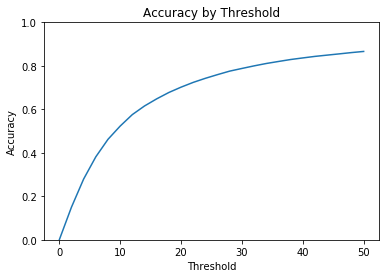

In [24]:
thresholds = [i for i in range(0, 51, 2)]
errors, avg_error, avg_accuracy = get_error(model, demo_loader, thresholds)
print("Average Error: $%3.2f" %(avg_error))
print("Average Accuracy with Threshold=20: %.2f" % avg_accuracy[thresholds.index(20)])
plt.plot(thresholds, avg_accuracy)
plt.xlabel("Threshold")

plt.ylabel("Accuracy")
plt.ylim((0, 1))
plt.title("Accuracy by Threshold")
plt.savefig("Sept 2019 Acc.png")
plt.show()


### 5.1 Analysis of Price Distribution

count    21303.000000
mean       146.127822
std        245.182840
min          0.000000
25%         68.000000
50%        103.000000
75%        170.000000
max      13244.000000
Name: price, dtype: float64


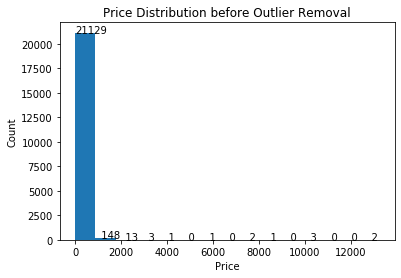

In [25]:
print((demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"]).describe())
#plt.hist((demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"]))

arr = plt.hist(demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"],bins=15)

for i in range(15):
    plt.text(arr[1][i],arr[0][i],"%5d" %(arr[0][i].round()))
plt.xlabel("Price")
plt.title("Price Distribution before Outlier Removal")
plt.ylabel("Count")
plt.savefig("Demo price dist 1.png")
plt.show()

### 5.2 Remove Outliers and Try Again

count    19187.000000
mean       124.000208
std         69.356823
min         36.000000
25%         70.000000
50%        105.000000
75%        159.000000
max        350.000000
Name: price, dtype: float64


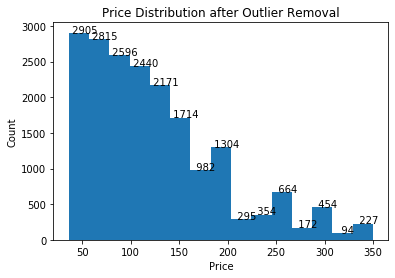

In [26]:
demo_df = demo_df[(demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"] >= 35) & (demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"] <= 350)]
print((demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"]).describe())

arr = plt.hist(demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"],bins=15)

for i in range(15):
    plt.text(arr[1][i],arr[0][i],"%5d" %(arr[0][i].round()))
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution after Outlier Removal")
plt.savefig("Demo price dist 2.png")
plt.show()

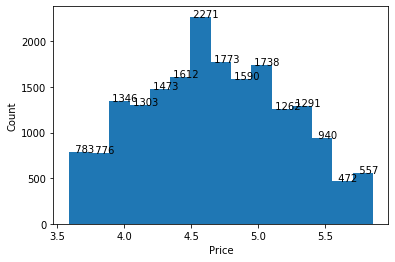

In [14]:
arr = plt.hist((demo_df["price"]*mean_std["std"]["price"]+mean_std["mean"]["price"]).apply(lambda x: np.log(x)),bins=15)

for i in range(15):
    plt.text(arr[1][i],arr[0][i],"%5d" %(arr[0][i].round()))
plt.xlabel("Price")
plt.ylabel("Count")
plt.savefig("Demo price dist 2.png")
plt.show()

Average Error: $18.09
Average Accuracy with Threshold=20: 0.74


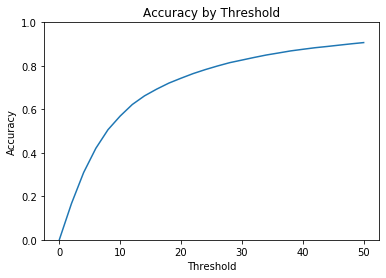

In [10]:
demo_ds = airbnb_dataset(demo_df, "demo")
demo_loader = DataLoader(demo_ds, batch_size=1000, shuffle=False, num_workers=0)

thresholds = [i for i in range(0, 51, 2)]
errors, avg_error, avg_accuracy = get_error(model, demo_loader, thresholds)
print("Average Error: $%3.2f" %(avg_error))
print("Average Accuracy with Threshold=20: %.2f" % avg_accuracy[thresholds.index(20)])
plt.plot(thresholds, avg_accuracy)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.ylim((0, 1))
plt.title("Accuracy by Threshold")
plt.show()